In [2]:
parent_path='../Data/New_Data_15-06-2020/'
%load_ext autoreload
%autoreload 2
import parmap
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from models.tokenization import *
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from models.model_architecture import *
from models.train_eval import *
from models.model_utils import *
from models.tokenization import *

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/punyajoy/.conda/envs/puny

In [ ]:
whatsapp_data=pd.read_csv(parent_path+'Data_text_spam_removed_v02.csv')
temp=whatsapp_data[['group_id_anonymized','phone_num_anonymized','message_text','timestamp']]
duplicateDFRow = temp[temp.duplicated()]
whatsapp_data=whatsapp_data.drop(list(duplicateDFRow.index))

In [ ]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data_final.pkl')

all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]



temp_data=whatsapp_data[whatsapp_data['group_id_anonymized'].isin(data_fear_speech.group_id_anonymized.unique())]

In [ ]:
n_process=30
params_preprocess={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': False}

def preprocess_split(df):
    preprocessed_sents=[preprocess_sent(ele,params=params_preprocess) for ele in tqdm(df['message_text'],total=len(df))]
    df['preprocessed']=preprocessed_sents
    return df


df_split = np.array_split(temp_data, n_process)
list_all = parmap.map(preprocess_split, df_split,pm_processes=n_process,pm_pbar=True)


In [ ]:
import gc
gc.collect()

In [ ]:
temp_data=pd.concat(list_all,axis=0)
temp_data

In [ ]:
params={'model_path':'xlm-roberta-base',
        'preprocess_doc':False,
        'max_length':256,
        'batch_size':32,
        'hidden_size':128,
        'weights':[1.0,3.0],
        'seq_model':'lstm',
        'data_path':parent_path+'Fearspeech_data_final.pkl',
        'max_sentences_per_doc':5,
        'transformer_type':'normal_transformer',
        'take_tokens_from':'both',
        'device':'cpu',
        'learning_rate':2e-5,
        'epsilon':1e-8,
        'random_seed':2020,
        'epochs':10,
        'max_memory':0.6,
        'freeze_bert':False
       }


In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference


def inference_phase(params,temp,fold):
    params_preprocess={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': False}
    if(params['preprocess_doc']==True):
        list_sents=[preprocess_doc(ele,params=params_preprocess) for ele in tqdm(temp['message_text'],total=len(temp))]
    else:
        list_sents=[preprocess_sent(ele,params=params_preprocess) for ele in tqdm(temp['message_text'],total=len(temp))]
    X_0 = np.array(list_sents,dtype='object')
    y_0 = np.array([0]*len(list_sents))
    tokenizer = AutoTokenizer.from_pretrained(params['model_path'])
    if torch.cuda.is_available() and params['device']=='cuda':    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        deviceID = get_gpu(params)
        torch.cuda.set_device(deviceID[0])
    else:
        print('Since you dont want to use GPU, using the CPU instead.')
        device = torch.device("cpu")
    X_test,X_test_mask= encode_sent(X_0,params,tokenizer)
    test_dataloader=return_dataloader_sent(X_test,X_test_mask,y_0,params,is_train=True)
    #params['model_path']='Saved/'+params['model_path']+'_'+str(fold)
    params['load_saved']=True
    model=select_transformer_model(params['transformer_type'],params['model_path'],params,fold)
    model.eval()    
    logits_all=[]
    # Evaluate data for one epoch
    for batch in tqdm(test_dataloader,total=len(test_dataloader)):
        # Add batch to GPU
        b_input_ids = batch[0].to(device)
        b_att_masks = batch[1].to(device)
        b_token_types = batch[2].to(device)
        b_labels = batch[3].to(device)
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            outputs = model(input_ids=b_input_ids, attention_mask=b_att_masks, token_type_ids=b_token_types)

        logits = outputs
        logits = logits.detach().cpu().numpy()
        
        
        logits_all+=list(logits)
        
    logits_all_final=[]
    for logits in logits_all:
        logits_all_final.append(softmax(logits)[1])
    
    return np.array(logits_all_final)

In [ ]:
for i in range(1,6):
    pred_labels=inference_phase(params,temp,1)
    temp['fold_'+str(i)]=list(pred_labels)

In [ ]:
temp

In [ ]:
whatsapp_data_pred=pd.read_csv(parent_path+'Data_text_spam_removed_v02_preds.csv')


In [ ]:
lexicon_path='../Data/Important_lexicon/'
########################################
def get_lexicon(type1,path):
    lexicon=[]
    with open(path+type1+'_keywords_complete.txt', 'r') as f:
        temp=f.read().splitlines()
    for word in temp:
        lexicon.append(word.split('_'))
    return lexicon

muslim_lexicon=get_lexicon('muslim',lexicon_path)
hindu_lexicon=get_lexicon('hindu',lexicon_path)


In [ ]:
from cltk.tokenize.word import WordTokenizer


# Cell
tok = WordTokenizer(language='multilingual')

def add_keywords(df1,lexicon,type_):
    occ_list=[]
    phrase_present=[]
    count_empty=0
    for index,row in tqdm_notebook(df1.iterrows(),total=len(df1)):
        temp=[]
        try:
            x=tok.tokenize(row['preprocessed'])
        except:
            x= ["dummy"]
        for y in lexicon:
            occ = [i for i,a in enumerate(x) if a == y[0]]
            for b in occ:
                  if x[b:b+len(y)] == y:
                    temp.append([b,b+len(y)])
        if(len(temp)>0):
            temp.sort(key=lambda interval: interval[0])
            merged = [temp[0]]
            for current in temp:
                previous = merged[-1]
                if current[0] <= previous[1]:
                    previous[1] = max(previous[1], current[1])
                else:
                    merged.append(current)
            occ_list.append(merged)
            phrase_present.append(len(merged))
        else:
            occ_list.append([])
            phrase_present.append(0)
            count_empty+=1
    df1[type_+'_phrases_count']=phrase_present
    #df1[type_+'_phrases_to_check']=occ_list
    return df1    
        

In [ ]:
#filtered_whatsapp_data=add_keywords(whatsapp_data_pred,hindu_lexicon,'hindu')
temp_data=add_keywords(temp_data,muslim_lexicon,'muslim')

In [ ]:
temp_data[temp_data['muslim_phrases_count']>0][['message_text']].sample(1000).to_csv('../muslim.csv',index=False)

In [ ]:
whatsapp_data_pred_2=filtered_whatsapp_data[(filtered_whatsapp_data['muslim_phrases_count']>0)]
whatsapp_data_pred_2.to_csv(parent_path+'Data_text_spam_removed_v02_preds.csv')

In [3]:
whatsapp_data_pred=pd.read_csv(parent_path+'Data_text_spam_removed_v03_preds.csv')

In [4]:
len(whatsapp_data_pred)

118627

In [5]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data_final.pkl')
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

whatsapp_data_pred=whatsapp_data_pred[~whatsapp_data_pred['orig_index'].isin(all_fear_speech_index)]
#data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


100%|██████████| 4782/4782 [00:00<00:00, 15430.40it/s]


In [6]:
len(whatsapp_data_pred)

110923

In [7]:
whatsapp_data_pred = whatsapp_data_pred[(whatsapp_data_pred['muslim_phrases_count']>0)]

In [8]:
whatsapp_data_pred

,Unnamed: 0,group_id_anonymized,phone_num_anonymized,message_text,timestamp,media_type,media_url,forwarded,orig_index,language,only_urls,is_spam,preprocessed,muslim_phrases_count,fold_1,fold_2,fold_3,fold_4,fold_5,fold_500
0,108,105,119,राहुल गांधी मुसलमान हैं केजरीवाल बेईमान हैं मा...,1549564154000,None,None,0,279,hi,0,0,राहुल गांधी मुसलमान हैं केजरीवाल बेईमान हैं मा...,1,0.023155,0.080758,0.022345,0.153330,0.057717,0.990506
1,123,113,128,*इरशाद अली* *सदस्य समाजवादी पार्टी उo प्रo*,1549564724000,None,None,0,346,ne,0,0,इरशाद अली सदस्य समाजवादी पार्टी उo प्रo,1,0.039817,0.022434,0.049344,0.235667,0.139789,0.659884
2,124,115,128,*इरशाद अली* *सदस्य समाजवादी पार्टी उo प्रo*,1549564733000,None,None,0,348,ne,0,0,इरशाद अली सदस्य समाजवादी पार्टी उo प्रo,1,0.065579,0.067829,0.249968,0.034211,0.107718,0.989240
3,125,112,128,*इरशाद अली* *सदस्य समाजवादी पार्टी उo प्रo*,1549564745000,None,None,0,349,ne,0,0,इरशाद अली सदस्य समाजवादी पार्टी उo प्रo,1,0.247880,0.083161,0.018854,0.116461,0.017570,0.947739
4,126,16,129,🌴 पैगाम 🌲🌲 एक बच्चा जला देने वाली गर्मी में न...,1549564858000,None,https://www.youtube.com/channel/UC2g347mT_09CX...,0,353,hi,0,0,पैगाम एक बच्चा जला देने वाली गर्मी में नंगे प...,7,0.036017,0.528478,0.596518,0.088715,0.182793,0.989416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118622,2505258,2234,64844,السلام علیکم ورحمۃاللہ وبرکاتہ 📖DARS E QUR'AAN...,1537351557000,None,None,65,6338876,ur,0,0,السلام علیکم ورحمۃاللہ وبرکاتہ dars e quraan ┯...,1,0.042194,0.146400,0.048670,0.615370,0.805953,0.836472
118623,2505259,2234,64844,⬛Ek Din Hazrat Imaam Hasan Radi-Allahu-Ta'aala...,1539251194000,None,None,65,6338877,id,0,0,ek din hazrat imaam hasan radiallahutaaalaanh...,5,0.028103,0.945475,0.016412,0.339912,0.041377,0.962496
118624,2505263,2234,64844,📜ARTICLE :- *🌹SEERAT E PAAK E RASOOL ﷺ*... ...,1539251195000,None,None,65,6338881,en,0,0,article seerat e paak e rasool ﷺ audio topic ...,2,0.036619,0.942351,0.042000,0.497476,0.013787,0.895637
118625,2505264,2234,64844,🔺ZABAN MAHFOOZ TO POORA JISM MAHFOOZ🔺 Sarkar...,1534769409000,None,None,65,6338882,so,0,0,zaban mahfooz to poora jism mahfooz sarkare d...,3,0.771676,0.567569,0.032099,0.042689,0.033624,0.967403


In [27]:
thresh=0.5
fear_speech_label=[]

for index,row in tqdm_notebook(whatsapp_data_pred.iterrows(),total=len(whatsapp_data_pred)):
    flag=0
    for i in range(1,6):
        if(row['fold_'+str(i)]>=thresh):
            flag+=1
            
    fear_speech_label.append(flag)

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [28]:
whatsapp_data_pred['fear_speech_label']=fear_speech_label

In [29]:
whatsapp_data_pred

,Unnamed: 0,group_id_anonymized,phone_num_anonymized,message_text,timestamp,media_type,media_url,forwarded,orig_index,language,...,is_spam,preprocessed,muslim_phrases_count,fold_1,fold_2,fold_3,fold_4,fold_5,fold_500,fear_speech_label
0,108,105,119,राहुल गांधी मुसलमान हैं केजरीवाल बेईमान हैं मायावती जातिवादी हैं ओर चौकीदार ही चोर हैँ! ठीक,1549564154000,None,None,0,279,hi,...,0,राहुल गांधी मुसलमान हैं केजरीवाल बेईमान हैं मायावती जातिवादी हैं ओर चौकीदार ही चोर हैँ ठीक,1,0.023155,0.080758,0.022345,0.153330,0.057717,0.990506,0
1,123,113,128,*इरशाद अली* *सदस्य समाजवादी पार्टी उo प्रo*,1549564724000,None,None,0,346,ne,...,0,इरशाद अली सदस्य समाजवादी पार्टी उo प्रo,1,0.039817,0.022434,0.049344,0.235667,0.139789,0.659884,0
2,124,115,128,*इरशाद अली* *सदस्य समाजवादी पार्टी उo प्रo*,1549564733000,None,None,0,348,ne,...,0,इरशाद अली सदस्य समाजवादी पार्टी उo प्रo,1,0.065579,0.067829,0.249968,0.034211,0.107718,0.989240,0
3,125,112,128,*इरशाद अली* *सदस्य समाजवादी पार्टी उo प्रo*,1549564745000,None,None,0,349,ne,...,0,इरशाद अली सदस्य समाजवादी पार्टी उo प्रo,1,0.247880,0.083161,0.018854,0.116461,0.017570,0.947739,0
4,126,16,129,"🌴 पैगाम 🌲🌲 एक बच्चा जला देने वाली गर्मी में नंगे पैर गुलदस्ते बेच रहा था लोग उसमे भी मोलभाव कर रहे थे। ☘एक आदमी को उसके पैर देखकर बहुत दुःख हुआ, उस आदमी ने बाज़ार से नया जूता ख़रीदा और उसे देते हुए कहा ""बेटा लो, ये जूता पहन लो"" . 🌸लड़के ने फ़ौरन जूते निकाले और पहन लिए . 🌼उसका चेहरा ख़ुशी से दमक उठा था. 🍀वो उस आदमी की तरफ़ पल्टा और हाथ थाम कर पूछा, ""आप अल्लाह हैं? . 🌻""उसने घबरा कर हाथ छुड़ाया और कानों को हाथ लगा कर कहा, ""नहीं बेटा, नहीं, मैं अल्लाह नहीं"" हुँ . 🌷लड़का फिर मुस्कराया और कहा, ""तो फिर ज़रूर अल्लाह के दोस्त होंगे, . 🌸क्योंकि मैंने कल रात अल्लाह से कहा था कि मुझे नऐ जूते देदें"". . ☘वो आदमी मुस्कुरा दिया और उसके सर को प्यार से चूमकर अपने घर की तरफ़ चल पड़ा. . ☘अब वो आदमी भी जान चुका था कि अल्लाह का दोस्त होना कोई मुश्किल काम नहीं.. . 🌺खुशियाँ बाटने से मिलती है 🌴 ""सूरेह यासीन"" -- फज्र के बाद पढ़ने से हर ख्वाहिश पूरी होती हे 🌲""सूरेह वाक़िया"" -- मगरिब के बाद पढ़ने से कभी फाका नहीं आता 🍀""सूरेह कौसर "" -- दुश्मनो की दुश्मनी से बचाती हे 🌸""सूरेह काफिरुंन"" -- मौत के वक़्त कुफ़्र से बचाती हे 🍁""सूरेह इखलास"" -- मुनाफ़िक़त से बचाती है 🌼""सूरेह फलक"" -- हादसों से बचाती हे 🌻""सूरेह नास"" -- वसवसो से बचाती हे 🌿ये तोहफा दुसरो को भी दे क्योंकि अल्लाह अज़्ज़ओ जल तोहफा देने वालो को पसंद फरमाता हे.. 💐💐💐💐💐 छोटी सी दुवा ""ए-अल्लाह"" जब तू अपनी रहमतो के दरवाजे खोले और पुकारे... ""है कोई रहमत मांगने वाला.? है कोई खुशिया मांगने वाला.? है कोई शिफा मांगने वाला.? है कोई मेरे ""महबूब"" (सल्ललाहो अलैही वसल्लम)"" की चाहत मांगने वाला.? तो मेरी दुआ है की, ""या अल्लाह"" सारी खुशियाँ सारी रहमते सारी कामयाबियाँ सारी बरकतें सारी नेअ़मतें ""नबी - ए - पाक"" ( सल्ललाहो अलैही वसल्लम )"" की चाहत उस शख्स को देदे जो ये मेसेज पढ़ के दुसरे को भी इस खूबसूरत दुआ में शामिल करे... *ईल्म -ए- ग़ैब चैनल* *यु ट्यूब चैनल क़ो सब्सक्राइब करें* लिंकः https://www.youtube.com/channel/UC2g347mT_09CX92XOG7eRDg *जज़्ज़ाकल्लाह*",1549564858000,None,https://www.youtube.com/channel/UC2g347mT_09CX92XOG7eRDg,0,353,hi,...,0,"पैगाम एक बच्चा जला देने वाली गर्मी में नंगे पैर गुलदस्ते बेच रहा था लोग उसमे भी मोलभाव कर रहे थे एक आदमी को उसके पैर देखकर बहुत दुःख हुआ उस आदमी ने बाज़ार से नया जूता ख़रीदा और उसे देते हुए कहा ""बेटा लो ये जूता पहन लो"" लड़के ने फ़ौरन जूते निकाले और पहन लिए उसका चेहरा ख़ुशी से दमक उठा था वो उस आदमी की तरफ़ पल्टा और हाथ थाम कर पूछा ""आप अल्लाह हैं ""उसने घबरा कर हाथ छुड़ाया और कानों को हाथ लगा कर कहा ""नहीं बेटा नहीं मैं अल्लाह नहीं"" हुँ लड़का फिर मुस्कराया और कहा ""तो फिर ज़रूर अल्लाह के दोस्त होंगे क्योंकि मैंने कल रात अल्लाह से कहा था कि मुझे नऐ जूते देदें"" वो आदमी मुस्कुरा दिया और उसके सर को प्यार से चूमकर अपने घर की तरफ़ चल पड़ा अब वो आदमी भी जान चुका था कि अल्लाह का दोस्त होना कोई मुश्किल काम नहीं खुशियाँ बाटने से मिलती है ""सूरेह यासीन"" फज्र के बाद पढ़ने से हर ख्वाहिश पूरी होती हे ""सूरेह वाक़िया"" मगरिब के बाद पढ़ने से कभी फाका नहीं आता ""सूरेह कौसर "" दुश्मनो की दुश्मनी से बचाती हे ""सूरेह काफिरुंन"" मौत के वक़्त कुफ़्र से बचाती हे ""सूरेह 

In [23]:
pd.set_option('display.max_colwidth', -1)

whatsapp_data_pred[whatsapp_data_pred['fear_speech_label']==1][['message_text','fold_500']]

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,message_text,fold_500
8,"*8 फ़रवरी की महत्त्वपूर्ण घटनाएँ⤵* 1238 - मंगाेलों ने व्लादिमीर नामक रूसी शहर को आग के हवाले किया। 1672 – भौतिकशास्त्री आइसक न्यूटन ने लंदन में आॅप्टिक और शोधपत्र प्रस्तुत किया। 1785 - 1774 से 1785 तक गर्वनर जनरल रहे वारेन हेस्टिंग्स ने भारत छोड़ा। 1802 – साइमन विलार्ड ने बैंजो क्लॉक का पेटेंट ​कराया। 1865 – पहली बार अमेरिकी सेना में किसी अश्वेत मार्टिन रॉबिसन डेलने को मेजर बनाया गया। 1872- अंडमान जेल (सेल्यूलर जेल या 'कालापानी') में शेर अली ने गवर्नर पर हमला करके शहादत प्राप्त की। 1879 – स्टैनफोर्ड फ्लेमिंग ने यूनीवर्सल स्टैंडर्ड टाइम को अपनाने का प्रस्ताव दिया। 1905 - हैती और उसके आस पास के द्वीप समूहों पर आये जबरदस्त चक्रवाती तूफान से दस हजार लोगों की मौत। 1909 - यूरोपीय देश फ्रांस और जर्मनी के बीच मोरक्को संधि पर हस्ताक्षर किये गये। 1922 – अमेरिकी राष्ट्रपति भवन ह्वाइट हाउस ने रोडियो का उपयोग शुरू किया। 1943 - स्वतंत्रता सेनानी नेताजी सुभाष चंद्र बोस जर्मनी के जेल से एक नौका के जरिये जापान के लिये रवाना हुये। 1952 – महारानी एलिजाबेथ ब्रिटेन की महारानी और राष्ट्रमंडल देशों की अध्यक्ष बनी। 1971 - दक्षिणी वियतनामी सेना ने लाओस पर हमला किया। 1971 – दुनिया के पहले इलेक्ट्रॉनिक शेयर बाजार नैस्डैक की शुरुआत हुई। 1974 – स्काईलैब अंतरिक्ष स्टेशन की तीन सदस्यीय चालक दल 84 दिन के बाद पृथ्वी पर लौटा। 1978 – अमेरिकी सीनेट की कार्यवाही को पहली बार रेडियो पर प्रसारित किया गया। 1986 – दिल्ली हवाई अड्डे पर पहली बार प्रीपेड टैक्सी सेवा शुरु की गई। 1992 – यूलिसिस अंतरिक्षयान बृहस्पति ग्रह के निकट से गुजरा। 1994 - क्रिकेटर कपिल देव ने टेस्ट मैचों में 432 विकेट लेकर रिचर्ड हैडली के सबसे अधिक विकेट लेने के विश्व रिकार्ड को ध्वस्त किया। 1999 - अमेरिकी अंतरिक्ष यान स्टारडस्ट केनेडी अंतरिक्ष केंद्र से रवाना। 2002 - भारत व रूस के बीच चार रक्षा समझौते सम्पन्न, विमानवाहक पोत गोर्शकोव का सौदा अटका। 2002 - अमेरिका के साल्ट लेक सिटी में 19वें शीतकालीन ओलंपिक खेल शुरु। 2005 - इस्रायल और फ़िलिस्तीन के बीच शर्म अल शेख़ (मिस्र) शिखर सम्मेलन में हिंसा समाप्त करने की घोषणा। 2006 - सिओल में भारत और दक्षिण कोरिया के बीच तीन समझौते सम्पन्न। 2007 - भूटान नरेश की प्रथम भारतीय यात्रा। 2008 - बैंगलौर स्थित इंडियन इंस्टीट्यूट ऑफ़ साइंस के वरिष्ठ वैज्ञानिक शांतनु भट्टाचार्य को जी.डी. बिड़ाला पुरस्कार से सम्मानित किया गया। 2008 - उत्तर प्रदेश विधानमण्डल का बजट सत्र प्रारंभ। 2008 - उड़ीसा के शिशुपालगढ़ में खुदाई के दौरान 2500 वर्ष पुराना शहर मिला। 2008 - अमेरिका में राष्ट्रपति पद के लिए हुए चुनाव में जॉन मैक्केन को रिपब्लिकन पार्टी का उम्मीदवार घोषित किया गया। 2008 - अमेरिका के अंतरिक्ष यान अटलांटिस को फ़्लोरिडा के केनवाल से अंतर्राष्ट्रीय अंतरिक्ष केन्द्र आईएसएस के लिए सफलतापूर्वक रवाना किया गया। 2009- हज़ारों पूर्व सैनिकों ने सरकार की बेरुखी से क्षुब्ध होकर अपने पदक राष्ट्रपति को लौटाए। 2010- श्रीनगर के पास खिलनमर्ग क्षेत्र में हिमस्खलन में सेना के हाई एल्टीट्यूड वारफेयर स्कूल के 350 जवान बर्फ़ के नीचे दब गए। इनमें से 70 सैनिकों को सुरक्षित निकाल लिया गया जबकि 11 सैनिकों के शव निकाले गए (2009 का भी वर्णन मिलता है इस खबर का इसलिए कन्फर्म कर लें)। 2014 - सऊदी अरब के मदीना शहर में एक होटल में आग के कारण 15 लोगों की मौत जबकि 130 लोग घायल हुए। *8 फ़रवरी को जन्मे व्यक्ति⤵* 1881 - वी.टी. कृष्णमाचारी - भारतीय सिविल सेवक और प्रशासक थे। 1897 - डॉ. ज़ाकिर हुसैन (विद्वान, तृतीय राष्ट्रपति-भारत) का जन्म आंध्रप्रदेश के हैदराबाद में हुआ। 1925 - शोभा गुर्टू - प्रसिद्ध भारतीय ठुमरी गायिका। 1928 - बाला देसाई - गोमांतक दल के सदस्य। 1939 - जेम्स माइकल लिंगदोह - भारत के बारहवें 'मुख्य चुनाव आयुक्त'। 1941 – गजलों की दुनिया के बादशाह जगजीत सिंह का जन्म हुआ। 1951 - अशोक चक्रधर - हिन्दी के मंचीय कवियों में से एक हैं। 1963 – प्रसिद्ध क्रिकेटर व भूतपूर्व भारतीय कप्तान अजरुद्दीन का हैदराबाद में जन्म हुआ। 1986 - एकता बिष्ट भारतीय महिला क्रिकेटर। *8 फ़रवरी को हुए निधन⤵* 1265 - हुलेगु ख़ान -'इलख़ानी साम्राज्य' के संस्थापक थे। 1971 - कन्हैयालाल माणिकलाल मुंशी - महान् लेखक और शिक्षाविद का बंबई (अब मुंबई)। 1995 - कल्पना दत्त - आज़ादी के लिए संघर्ष करने वाली महिला क्रांतिकारियों में से एक। *8 फ़रवरी के महत्त्वपूर्ण अवसर एवं उत्सव⤵* 🔅 _डॉ. जाकिर हुसैन जयन्ती ।_ 🔅 _मो. अजहरूद्दीन जन्म दिवस ।_ 🔅 _महिला क्रान्तिकारी कल्पना दत्त स्मृति दिवस ।_ 🔅 _सडक सुरक्षा सप्ताह 04 फरवरी 2019 से

In [31]:
temp=whatsapp_data_pred[whatsapp_data_pred['fear_speech_label']>1][['message_text','fold_1','fold_2','fold_3','fold_4','fold_5']]

In [ ]:
whatsapp_data_pred[whatsapp_data_pred['fold_1']>0.9].sample(1).iloc[0]['message_text']

In [32]:
temp.to_csv(parent_path+'Fear_speech_inferred.csv',index=False)

In [ ]:
whatsapp_data_pred.loc[127]

In [ ]:
for i in range(0,1000,5):
    print(i)

In [ ]:
from collections import OrderedDict 
group_dict={}
for group in data_fear_speech.phone_num_anonymized.unique():
    temp=data_fear_speech[data_fear_speech['phone_num_anonymized']==group]
    group_dict[group]=len(temp)
dict1 = sorted(group_dict.items(),key=lambda item: item[1],reverse=True)

selected_groups=[ele[0] for ele in dict1[0:100]]
len(selected_groups)

In [ ]:
temp=whatsapp_data_pred[whatsapp_data_pred['phone_num_anonymized'].isin(selected_groups)]['message_text']

In [ ]:
temp.to_csv(parent_path+'Fear_speech_user.csv',index=False)

In [ ]:
def return_probab(sentences_list):
    """Input: should be a list of sentences"""
    """Ouput: probablity values"""
    
    
    
    params=return_params(model_dict_params[model_to_use])
    
    device = torch.device("cpu")
    embeddings=None
    if(params['bert_tokens']):
        train,val,test=createDatasetSplit(params)
        vocab_own=None    
        vocab_size =0
        padding_idx =0
    else:
        train,val,test,vocab_own=createDatasetSplit(params)
        params['embed_size']=vocab_own.embeddings.shape[1]
        params['vocab_size']=vocab_own.embeddings.shape[0]
        embeddings=vocab_own.embeddings
    if(params['auto_weights']):
        y_test = [ele[2] for ele in test] 
        encoder = LabelEncoder()
        encoder.classes_ = np.load('Data/classes.npy')
        params['weights']=class_weight.compute_class_weight('balanced',np.unique(y_test),y_test).astype('float32')
   
    
    temp_read=transform_dummy_data(sentences_list)
    test_data=get_test_data(temp_read,params,message='text')
    test_extra=encodeData(test_data,vocab_own,params)
    test_dataloader=combine_features(test_extra,params,is_train=False)
    
    
    model=select_model(params,embeddings)
    if(params['bert_tokens']==False):
        model=load_model(model,params)
        
    model.eval()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    # Tracking variables
    post_id_all=list(test_data['Post_id'])
    
    print("Running eval on test data...")
    t0 = time.time()
    true_labels=[]
    pred_labels=[]
    logits_all=[]
    #attention_all=[]
    input_mask_all=[]
    
    # Evaluate data for one epoch
    for step, batch in tqdm_notebook(enumerate(test_dataloader),total=len(test_dataloader)):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)


        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention vals
        #   [2]: attention mask
        #   [3]: labels 
        b_input_ids = batch[0].to(device)
        b_att_val = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)


        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        outputs = model(b_input_ids,
            attention_vals=b_att_val,
            attention_mask=b_input_mask, 
            labels=None,device=device)
        logits = outputs[0]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy()
        
#         if(params['bert_tokens']):
#             attention_vectors=np.mean(outputs[1][11][:,:,0,:].detach().cpu().numpy(),axis=1)
#         else:
#             attention_vectors= outputs[1].detach().cpu().numpy()
           
        
        # Calculate the accuracy for this batch of test sentences.
        # Accumulate the total accuracy.
        pred_labels+=list(np.argmax(logits, axis=1).flatten())
        true_labels+=list(label_ids.flatten())
        logits_all+=list(logits)
        #attention_all+=list(attention_vectors)
        input_mask_all+=list(batch[2].detach().cpu().numpy())
    
    
    logits_all_final=[]
    for logits in logits_all:
        logits_all_final.append(list(softmax(logits)))

    
    return np.array(logits_all_final)

In [4]:
params={'model_path':'xlm-roberta-base',
        'preprocess_doc':False,
        'max_length':256,
        'batch_size':16,
        'hidden_size':128,
        'weights':[1.0,1.0],
        'load_saved':True,
        'seq_model':'lstm',
        'data_path':parent_path+'Fearspeech_data_final.pkl',
        'max_sentences_per_doc':5,
        'transformer_type':'normal_transformer',
        'take_tokens_from':'last',
        'device':'cpu',
        'learning_rate':2e-5,
        'epsilon':1e-8,
        'random_seed':2020,
        'epochs':20,
        'max_memory':0.6,
        'freeze_bert':False
       }

In [87]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    temp=e_x / e_x.sum(axis=0) # only difference
    
    if np.isnan(temp).any()==True:
        return [0.0,1.0,0.0]
    else:
        return temp

class modelPred():
    def __init__(self,params,fold):
        self.params=params
        if torch.cuda.is_available() and self.params['device']=='cuda':    
            # Tell PyTorch to use the GPU.    
            self.device = torch.device("cuda")
            deviceID = get_gpu(self.params)
            torch.cuda.set_device(deviceID[0])
        else:
            print('Since you dont want to use GPU, using the CPU instead.')
            self.device = torch.device("cpu")

        self.model=select_transformer_model(params['transformer_type'],params['model_path'],params,count_skf)
        #self.model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")

        if(self.params["device"]=='cuda'):
            self.model.cuda()
        self.model.eval()
    
    def return_probab(self,sentences_list):
        """Input: should be a list of sentences"""
        """Ouput: probablity values"""
        params=self.params
        device = self.device

        X_test,X_test_mask= encode_sent(sentences_list,params,tokenizer)
        y_test=np.zeros((len(X_test),))
        test_dataloader=return_dataloader_sent(X_test,X_test_mask,y_test,params,is_train=False)
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        # Tracking variables
        

        print("Running eval on test data...")
        t0 = time.time()
        true_labels=[]
        pred_labels=[]
        logits_all=[]
        #attention_all=[]
        input_mask_all=[]

        # Evaluate data for one epoch
        for step, batch in tqdm(enumerate(test_dataloader),total=len(test_dataloader)):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)


            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention vals
            #   [2]: attention mask
            #   [3]: labels 
            b_input_ids = batch[0].to(device)
            b_att_val = batch[1].to(device)
            b_input_mask = batch[2].to(device)
            b_labels = batch[3].to(device)


            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            #model.zero_grad()        
            outputs = self.model(b_input_ids,
                attention_mask=b_input_mask, 
                labels=None)
            logits = outputs

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.detach().cpu().numpy()

    #         if(params['bert_tokens']):
    #             attention_vectors=np.mean(outputs[1][11][:,:,0,:].detach().cpu().numpy(),axis=1)
    #         else:
    #             attention_vectors= outputs[1].detach().cpu().numpy()


            # Calculate the accuracy for this batch of test sentences.
            # Accumulate the total accuracy.
            
            pred_labels+=list(np.argmax(logits, axis=1).flatten())
            true_labels+=list(label_ids.flatten())
            logits_all+=list(logits)
            #attention_all+=list(attention_vectors)
            input_mask_all+=list(batch[2].detach().cpu().numpy())


        logits_all_final=[]
        for logits in logits_all:
            logits_all_final.append(list(softmax(logits)))


        return np.array(logits_all_final)

In [88]:
import random 
#from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 
# 
annotated_df=pd.read_pickle(params['data_path'])
params_preprocess={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': False}
list_sents=[preprocess_sent(ele,params=params_preprocess) for ele in tqdm_notebook(annotated_df['message_text'],total=len(annotated_df))]
X_0 = np.array(list_sents,dtype='object')
y_0 = np.array(annotated_df['one_fear_speech'])
if(params['weights']== [1.0,1.0]):
    params['weights']=list(class_weight.compute_class_weight("balanced", np.unique(y_0),y_0).astype(float))

print('Loading tokenizer...')


#tokenizer = AutoTokenizer.from_pretrained("jpcorb20/toxic-detector-distilroberta")
#tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")


tokenizer = AutoTokenizer.from_pretrained(params['model_path'])
#torch.autograd.set_detect_anomaly(True)
if torch.cuda.is_available() and params['device']=='cuda':    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    deviceID = get_gpu(params)
    torch.cuda.set_device(deviceID[0])
else:
    print('Since you dont want to use GPU, using the CPU instead.')
    device = torch.device("cpu")


list_dict=[]
skf = StratifiedKFold(n_splits=5, random_state= 2020)
count_skf=0


#explainer = LimeTextExplainer(class_names=['non fear speech','fear speech'],split_expression='\s+',random_state=333,bow=False)

y_ground_all=[]
y_pred_all=[]

for train_index, test_index in skf.split(X_0, y_0):
    print('======== Fold {:} / {:} ========'.format(count_skf,5))
    print(train_index[0:5], test_index[0:5])
    count_skf+=1
    print("")
    X_train, X_test = X_0[train_index], X_0[test_index]
    y_train, y_test = y_0[train_index], y_0[test_index]
    
    
    model_cl=modelPred(params,count_skf)
    
    
    logits_all_final=model_cl.return_probab(X_test)
    
    index_ground_nfs=[]
    index_ground_fs=[]
    
    
    for i in tqdm(range(len(y_test))):
        pred_id=np.argmax(logits_all_final[i])
        ground_label=y_test[i]
        y_ground_all.append(ground_label)
        y_pred_all.append(pred_id)
        if(pred_id!=ground_label):
            if(ground_label==1):
                index_ground_fs.append(i)
            else:
                index_ground_nfs.append(i)
    
#     for i in random.sample(index_ground_fs,20):
#         temp={}
#         exp = explainer.explain_instance(X_test[i], model_cl.return_probab, num_features=6, top_labels=2,num_samples=50)
#         pred_id=np.argmax(exp.predict_proba)
#         ground_label=y_test[i]
#         temp["text"]=X_test[i]
#         temp["annotation"]=ground_label
#         temp["classification"]=pred_id
#         temp["classification_scores"]={"non fear speech":exp.predict_proba[0],"fear speech":exp.predict_proba[1]}
#         temp["text_explained"]=exp.as_list()
#         list_dict.append(temp)
    
#     for i in random.sample(index_ground_nfs,20):
#         temp={}
#         exp = explainer.explain_instance(X_test[i], model_cl.return_probab, num_features=6, top_labels=2,num_samples=50)
#         pred_id=np.argmax(exp.predict_proba)
#         ground_label=y_test[i]
#         temp["text"]=X_test[i]
#         temp["annotation"]=ground_label
#         temp["classification"]=pred_id
#         temp["classification_scores"]={"non fear speech":exp.predict_proba[0],"fear speech":exp.predict_proba[1]}
#         temp["text_explained"]=exp.as_list()
#         list_dict.append(temp)

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Loading tokenizer...
Since you dont want to use GPU, using the CPU instead.


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


======== Fold 0 / 5 ========
[870 872 873 874 875] [0 1 2 3 4]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 957/957 [00:00<00:00, 106725.58it/s]


======== Fold 1 / 5 ========
[0 1 2 3 4] [870 872 873 874 875]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 957/957 [00:00<00:00, 237596.12it/s]


======== Fold 2 / 5 ========
[0 1 2 3 4] [1771 1772 1773 1774 1775]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 956/956 [00:00<00:00, 82332.44it/s]


======== Fold 3 / 5 ========
[0 1 2 3 4] [2757 2758 2759 2761 2762]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 956/956 [00:00<00:00, 105011.38it/s]


======== Fold 4 / 5 ========
[0 1 2 3 4] [3792 3794 3796 3799 3801]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 956/956 [00:00<00:00, 250453.13it/s]


In [89]:
from sklearn.metrics import confusion_matrix,make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support



In [90]:
testf1=f1_score(y_ground_all, y_pred_all, average='macro')
testacc=accuracy_score(y_ground_all,y_pred_all)
testrocauc=roc_auc_score(y_ground_all, y_pred_all,average='macro')
testprecision=precision_score(y_ground_all, y_pred_all, average='binary')

In [91]:
 print('val_fscore',testf1)
print('val_accuracy',testacc)
print('val_rocauc',testrocauc)
print('val_precision',testprecision)

val_fscore 0.6792295266059775
val_accuracy 0.7561689669594313
val_rocauc 0.6880999692076749
val_precision 0.49075500770416025


In [92]:
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


with open('lime_explanation.txt', 'w') as fp:
        
    for ele in list_dict:
        fp.write("====================Start=======================\n")
        fp.write(json.dumps(ele,cls=NumpyEncoder,ensure_ascii=False))
        fp.write("====================End=======================\n")
        
        

In [93]:
len(list_dict)

0

In [94]:
from sklearn.metrics import confusion_matrix#Fit the model
cf_matrix = confusion_matrix(y_ground_all,y_pred_all)
print(cf_matrix)

[[2979  661]
 [ 505  637]]


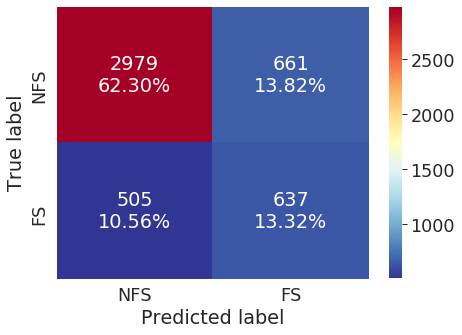

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (7, 5)
sns.set(context='paper',style='white',font_scale=2.0)

#labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
categories = ['NFS', 'FS']
make_confusion_matrix(cf_matrix,
                      categories=categories, 
                      cmap='RdYlBu_r',
                      sum_stats=False)
plt.savefig('../Fear_speech_results/confusion_matrix.pdf',bbox_inches='tight',dpi=400)

In [13]:
plt.show()

In [70]:
lexicon_path='../Data/Important_lexicon/'
########################################
def get_lexicon(type1,path):
    lexicon=[]
    with open(path+type1, 'r') as f:
        temp=f.read().splitlines()
    for word in temp:
        lexicon.append(word)
    return lexicon

hate_lexicon=get_lexicon('hate_lexicon.txt',lexicon_path)
hate_lexicon

['नफरत',
 'chaude',
 'hate ',
 'hatred',
 'murder',
 'murderer',
 'rape',
 'नीच',
 'irritate',
 'irritating',
 'killing',
 'धमकी',
 'fake',
 'उल्लू बनाना',
 'चूतिया ',
 'चूतिये',
 'खिलाफ',
 'ख़िलाफ़ ',
 'धोखा',
 'घमंड ',
 'घमंडी',
 'गांड',
 'गन्दी ',
 'bitch',
 'गन्दगी',
 'झूठ',
 'lie',
 'liar',
 'झूठा',
 'झूटी',
 'साला',
 'सालो',
 'घटिया',
 'corrupt',
 'corruption',
 'terror',
 'terrorist',
 'terrorism',
 'attack',
 'attacks',
 'pedophile',
 'शर्म',
 'चोर',
 'thief',
 'pagal',
 'कुतिया',
 'कुत्ता ',
 'कुत्ते ',
 'maut',
 'मौत',
 'सुवर',
 'पिग',
 'बकवास ',
 'kill',
 'filth',
 'filthy',
 'disgust',
 'disgusting',
 'extortion',
 'jail',
 'घोटाला',
 'punish',
 'गन्दगी',
 'कलंक ',
 'बेहूदा ',
 'bitching',
 'freaking ',
 'ugly',
 'nonsense',
 'बलात्कारी ',
 'कमीनो',
 'Rascal',
 'देशद्रोह ',
 'चुतियो',
 'oppose',
 'विरोध ',
 'दलाली',
 'गांड',
 'crime',
 'criminal',
 'दंगे',
 'rapist',
 'blast',
 'blasts',
 'हरामखोर',
 'slavery',
 'genocide',
 'bloody',
 'हरामियों',
 'retarded',
 'हरामज़ादे',
 '

In [77]:
import random 

annotated_df=pd.read_pickle(params['data_path'])
params_preprocess={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': True}
list_sents=[preprocess_sent(ele,params=params_preprocess) for ele in tqdm_notebook(annotated_df['message_text'],total=len(annotated_df))]
X_0 = np.array(list_sents,dtype='object')
y_0 = np.array(annotated_df['one_fear_speech'])

list_dict=[]
skf = StratifiedKFold(n_splits=5, random_state= 2020)
count_skf=0


#explainer = LimeTextExplainer(class_names=['non fear speech','fear speech'],split_expression='\s+',random_state=333,bow=False)

y_ground_all=[]
y_pred_all=[]

for train_index, test_index in skf.split(X_0, y_0):
    print('======== Fold {:} / {:} ========'.format(count_skf,5))
    print(train_index[0:5], test_index[0:5])
    count_skf+=1
    print("")
    X_train, X_test = X_0[train_index], X_0[test_index]
    y_train, y_test = y_0[train_index], y_0[test_index]
    
    
    index_ground_nfs=[]
    index_ground_fs=[]
    
    
    for i in tqdm(range(len(y_test))):
        pred_id=0
        for ele in X_test[i]:
            if ele in hate_lexicon:
                pred_id=1
                break
            

        ground_label=y_test[i]
        y_ground_all.append(ground_label)
        y_pred_all.append(pred_id)
        if(pred_id!=ground_label):
            if(ground_label==1):
                index_ground_fs.append(i)
            else:
                index_ground_nfs.append(i)
    

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


  0%|          | 0/957 [00:00<?, ?it/s]

  7%|▋         | 68/957 [00:00<00:01, 673.32it/s]


======== Fold 0 / 5 ========
[870 872 873 874 875] [0 1 2 3 4]





 28%|██▊       | 269/957 [00:00<00:00, 840.25it/s]

 62%|██████▏   | 594/957 [00:00<00:00, 1080.33it/s]

100%|██████████| 957/957 [00:00<00:00, 2107.37it/s]


  0%|          | 0/957 [00:00<?, ?it/s]

 25%|██▌       | 242/957 [00:00<00:00, 2419.37it/s]

 41%|████      | 389/957 [00:00<00:00, 2023.47it/s]

======== Fold 1 / 5 ========
[0 1 2 3 4] [870 872 873 874 875]





 56%|█████▌    | 535/957 [00:00<00:00, 1812.86it/s]

 70%|██████▉   | 666/957 [00:00<00:00, 1622.55it/s]

100%|██████████| 957/957 [00:00<00:00, 1707.52it/s]


  0%|          | 0/956 [00:00<?, ?it/s]

 22%|██▏       | 210/956 [00:00<00:00, 2097.55it/s]

======== Fold 2 / 5 ========
[0 1 2 3 4] [1771 1772 1773 1774 1775]





 39%|███▉      | 373/956 [00:00<00:00, 1927.70it/s]

 57%|█████▋    | 543/956 [00:00<00:00, 1849.41it/s]

 74%|███████▍  | 707/956 [00:00<00:00, 1776.44it/s]

100%|██████████| 956/956 [00:00<00:00, 1610.33it/s]


  0%|          | 0/956 [00:00<?, ?it/s]

 16%|█▌        | 153/956 [00:00<00:00, 1522.18it/s]

 31%|███       | 294/956 [00:00<00:00, 1484.86it/s]

======== Fold 3 / 5 ========
[0 1 2 3 4] [2757 2758 2759 2761 2762]





 48%|████▊     | 455/956 [00:00<00:00, 1514.57it/s]

 64%|██████▍   | 614/956 [00:00<00:00, 1532.61it/s]

 80%|███████▉  | 764/956 [00:00<00:00, 1521.55it/s]

100%|██████████| 956/956 [00:00<00:00, 1439.23it/s]


  0%|          | 0/956 [00:00<?, ?it/s]

 14%|█▎        | 131/956 [00:00<00:00, 1291.23it/s]



======== Fold 4 / 5 ========
[0 1 2 3 4] [3792 3794 3796 3799 3801]



 34%|███▎      | 321/956 [00:00<00:00, 1424.89it/s]

 58%|█████▊    | 558/956 [00:00<00:00, 1613.92it/s]

100%|██████████| 956/956 [00:00<00:00, 2116.31it/s]


In [80]:
testf1=f1_score(y_ground_all, y_pred_all, average='macro')
testacc=accuracy_score(y_ground_all,y_pred_all)
testrocauc=roc_auc_score(y_ground_all, y_pred_all,average='macro')
testprecision=precision_score(y_ground_all, y_pred_all, average='binary')

In [81]:
print('val_fscore',testf1)
print('val_accuracy',testacc)
print('val_rocauc',testrocauc)
print('val_precision',testprecision)

val_fscore 0.5369804981062387
val_accuracy 0.6210790464240903
val_rocauc 0.5479840649718057
val_precision 0.2908863920099875
